In [1]:
try:
  import pytorch_lightning as pl
except: 
  !pip install pytorch-lightning
  import pytorch_lightning as pl

# Preprocessing

In [2]:
# Options
run_preprocessing = False

import os

if run_preprocessing:
    # Download repo if notebook is taken out of context (e.g. by colab)
    if not os.path.exists('scripts'):
      !git clone https://github.com/MachineLearningLifeScience/What-is-a-meaningful-representation-of-protein-sequences tmp_clone
      !mv tmp_clone/* .
      !rm -rf tmp_clone

    !pip install bioservices
    
    import scripts.exp7_preprocessing

    # Run preprocessing script
    scripts.exp7_preprocessing.process_data(os.getcwd())
else:
    # Retrieve ready-made files
    if not os.path.exists('BLAT_ECOLX_1_b0.5_labeled.fasta'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled.fasta
    if not os.path.exists('BLAT_ECOLX_alignment_clustalo_maxalign.fasta'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_alignment_clustalo_maxalign.fasta
        
# Check that files exist
assert os.path.exists('BLAT_ECOLX_1_b0.5_labeled.fasta')
assert os.path.exists('BLAT_ECOLX_alignment_clustalo_maxalign.fasta')

# Training

In [3]:
import pytorch_lightning as pl
import torch
import torch.nn.functional as F
import numpy as np
from Bio import SeqIO

from models.vae_geometric import VAE, get_hparams, aa1_to_index, aa1

def train_or_retrieve_model(name, data_filename, train_model, reweighted):

    ids = []
    seqs = []
    for record in SeqIO.parse(data_filename, "fasta"):
        ids.append(record.id)
        seqs.append(np.array([aa1_to_index[aa] for aa in str(record.seq).upper().replace('.', '-')]))
    seqs = torch.from_numpy(np.vstack(seqs))
            
    args = []
    if train_model:
        args += ['-gpu', 0]
    else:
        args += ['-load_from', name+'.ckpt', '-gpu', 0]
    hparams = get_hparams(args)

    pl.seed_everything(hparams.seed)

    weights = None
    if reweighted is not False:
        one_hot = F.one_hot(seqs.long())
        one_hot[seqs>19] = 0
        flat_one_hot = one_hot.flatten(1)
        del one_hot

        weights = []
        weight_batch_size = 1000
        flat_one_hot = flat_one_hot.float()
        for i in range(seqs.size(0) // weight_batch_size + 1):
            x = flat_one_hot[i * weight_batch_size : (i + 1) * weight_batch_size]
            similarities = torch.mm(x, flat_one_hot.T)
            lengths = (seqs[i * weight_batch_size : (i + 1) * weight_batch_size] <=19).sum(1).unsqueeze(-1)
            w = 1.0 / (similarities / lengths).gt(0.8).sum(1).float()
            weights.append(w)
        weights = torch.cat(weights)
        neff = weights.sum()        
    
    perm = np.random.permutation(seqs.shape[0])
    
    if hparams.load_from!='':
        
        if not os.path.exists(hparams.load_from):
            filename = os.path.join('wget https://sid.erda.dk/share_redirect/a5PTfl88w0/', hparams.load_from)
            !wget $filename
        
        print('Loading from checkpoint!')
        model = VAE.load_from_checkpoint(checkpoint_path=hparams.load_from, data=seqs, perm=perm, weights=weights)
        # for some reason these where not correctly saved in the checkpoint
        model.switch = True
        model.distnet.initialized = True
        
        # Model fit specific parameter setting the temperature of the uncertainty
        model.distnet.trans.beta.data = torch.tensor([-0.1])
        
        # model.hparams.train_fraction = 0.8
        # model.hparams.val_fraction = 0.1
        # trainer = pl.Trainer(resume_from_checkpoint=hparams.load_from)
        # trainer.model = model
        # trainer.save_checkpoint(name+'_updated.ckpt')

    else:
        print('Training model!')
        model = VAE(data=seqs, weights=weights, perm=perm, hparams=hparams)
        trainer = pl.Trainer(gpus=1 if hparams.gpu else 0,
                             max_epochs=hparams.epochs)
        trainer.fit(model)

    return model

In [4]:
# Options
train_models = False

model_qc   = train_or_retrieve_model('model_BLAT_ECOLX_query_centric', 
                                     'BLAT_ECOLX_1_b0.5_labeled.fasta', 
                                     train_model=train_models, reweighted=False)
model_qc_r = train_or_retrieve_model('model_BLAT_ECOLX_query_centric_reweighted', 
                                     'BLAT_ECOLX_1_b0.5_labeled.fasta', 
                                     train_model=train_models, reweighted=True)
model_ra   = train_or_retrieve_model('model_BLAT_ECOLX_realigned', 
                                     'BLAT_ECOLX_alignment_clustalo_maxalign.fasta', 
                                     train_model=train_models, reweighted=True)
model_ra_r = train_or_retrieve_model('model_BLAT_ECOLX_realigned_reweighted', 
                                     'BLAT_ECOLX_alignment_clustalo_maxalign.fasta', 
                                     train_model=train_models, reweighted=False)
models = [model_qc, model_qc_r, model_ra, model_ra_r]

Loading from checkpoint!
Loading from checkpoint!
Loading from checkpoint!
Loading from checkpoint!


# Alignment & embedding

In [4]:
embeddings = []
for model in models:
    embeddings.append([])
    batchsize = 16
    n_batch = int(np.ceil(model.data.shape[0] / batchsize))
    for b in range(n_batch):
        batch = model.data[b*batchsize:(b+1)*batchsize]
        zs = model.embedding(batch.long().to(model._device))
        embeddings[-1].append(zs.detach())
    embeddings[-1] = np.vstack(embeddings[-1])

In [12]:
queries = {'A1': 
           {'TEM-1': "MSIQHFRVALIPFFAAFCLPVFAHPETLVKVKDAEDQLGARVGYIELDLNSGKILESFRPEERFPMMSTFKVLLCGAVLSRVDAGQEQLGRRIHYSQNDLVEYSPVTEKHLTDGMTVRELCSAAITMSDNTAANLLLTTIGGPKELTAFLHNMGDHVTRLDRWEPELNEAIPNDERDTTMPAAMATTLRKLLTGELLTLASRQQLIDWMEADKVAGPLLRSALPAGWFIADKSGAGERGSRGIIAALGPDGKPSRIVVIYTTGSQATMDERNRQIAEIGASLIKHW",
            'SHV-1': "MRYIRLCIISLLATLPLAVHASPQPLEQIKLSESQLSGRVGMIEMDLASGRTLTAWRADERFPMMSTFKVVLCGAVLARVDAGDEQLERKIHYRQQDLVDYSPVSEKHLADGMTVGELCAAAITMSDNSAANLLLATVGGPAGLTAFLRQIGDNVTRLDRWETELNEALPGDARDTTTPASMAATLRKLLTSQRLSARSQRQLLQWMVDDRVAGPLIRSVLPAGWFIADKTGAGERGARGIVALLGPNNKAERIVVIYLRDTPASMAERNQQIAGIGAALIEHWQR",
            'PSE-1': "MKFLLAFSLLIPSVVFASSSKFQQVEQDVKAIEVSLSARIGVSVLDTQNGEYWDYNGNQRFPLTSTFKTIACAKLLYDAEQGKVNPNSTVEIKKADLVTYSPVIEKQVGQAITLDDACFATMTTSDNTAANIILSAVGGPKGVTDFLRQIGDKETRLDRIEPDLNEGKLGDLRDTTTPKAIASTLNKFLFGSALSEMNQKKLESWMVNNQVTGNLLRSVLPAGWNIADRSGAGGFGARSITAVVWSEHQAPIIVSIYLAQTQASMAERNDAIVKIGHSIFDVYTSQSR",
            'RTG-2': "MNVRKHKASFFSVVITFLCLTLSLNANATDSVLEAVTNAETELGARIGLAVHDLETGKRWEHKSNERFPLSSTFKTLACANVLQRVDLGKERIDRVVRFSESNLVTYSPVTEKHVGKKGMSLAELCQATLSTSDNSAANFILQAIGGPKALTKFLRSIGDDTTRLDRWETELNEAVPGDKRDTTTPIAMVTTLEKLLIDETLSIKSRQQLESWLKGNEVGDALFRKGVPSDWIVADRTGAGGYGSRAITAVMWPPNRKPIVAALYITETDASFEERNAVIAKIGEQIAKTVLMENSRN",
            'CumA' : "MTMFKTTFRQTATIAVSLISLLVSPMLWANTNNTIEEQLSTLEKYSQGRLGVALINTEDNSQITYRGEERFAMASTSKVMAVAAVLKESEKQAGLLDKNITIKKSDLVAYSPITEKHLVTGMSLAQLSAATLQYSDNTAMNKILDYLGGPAKVTQFARSINDVTYRLDRKEPELNTAIHGDPRDTTSPIAMAKSLQALTLGDALGQSQRQQLVTWLKGNTTGDHSIKAGLPKHWIVGDKTGSGDYGTTNDIAVIWPKNHAPLILVVYFTQQEQDAKYRKDIIVKATEIVTKEISNSPQTK",
            'OXY-1': "MLKSSWRKTALMAAAAVPLLLASGSLWASADAIQQKLADLEKRSGGRLGVALINTADDSQTLYRGDERFAMCSTGKVMAAAAVLKQSESNPEVVNKRLEIKKSDLVVWSPITEKHLQSGMTLAELSAAALQYSDNTAMNKMISYLGGPEKVTAFAQSIGDVTFRLDRTEPALNSAIPGDKRDTTTPLAMAESLRKLTLGNALGEQQRAQLVTWLKGNTTGGQSIRAGLPASWAVGDKTGAGDYGTTNDIAVIWPENHAPLVLVTYFTQPQQDAKSRKEVLAAAAKIVTEGL",
            'KLUA-1': "MMTQSIRRSMLTVMATLPLLFSSATLHAQANSVQQQLEALEKSSGGRLGVALINTADNSQILYRADERFAMCSTSKVMAAAAVLKQSESDKHLLNQRVEIKKSDLVNYNPIAEKHVNGTMTLAELGAAALQYSDNTAMNKLIAHLGGPDKVTAFARSLGDETFRLDRTEPTLNTAIPGDPRDTTTPLAMAQTLKNLTLGKALAETQRAQLVTWLKGNTTGSASIRAGLPKSWVVGDKTGSGDYGTTNDIAIIWPENHAPLVLVTYFTQPEQKAESRRDVLAAAAKIVTHGF",
            'CTX-M-1': "MVKKSLRQFTLMATATVTLLLGSVPLYAQTADVQQKLAELERQSGGRLGVALINTADNSQILYRADERFAMCSTSKVMAVAAVLKKSESEPNLLNQRVEIKKSDLVNYNPIAEKHVDGTMSLAELSAAALQYSDNVAMNKLISHVGGPASVTAFARQLGDETFRLDRTEPTLNTAIPGDPRDTTSPRAMAQTLRNLTLGKALGDSQRAQLVTWMKGNTTGAASIQAGLPASWVVGDKTGSGDYGTTNDIAVIWPKDRAPLILVTYFTQPQPKAESRRDVLASAAKIVTNGL",
            'NMCA': "MSLNVKQSRIAILFSSCLISISFFSQANTKGIDEIKNLETDFNGRIGVYALDTGSGKSFSYRANERFPLCSSFKGFLAAAVLKGSQDNRLNLNQIVNYNTRSLEFHSPITTKYKDNGMSLGDMAAAALQYSDNGATNIILERYIGGPEGMTKFMRSIGDEDFRLDRWELDLNTAIPGDERDTSTPAAVAKSLKTLALGNILSEHEKETYQTWLKGNTTGAARIRASVPSDWVVGDKTGSCGAYGTANDYAVVWPKNRAPLIISVYTTKNEKEAKHEDKVIAEASRIAIDNLK",
            'SME-1': "MSNKVNFKTASFLFSVCLALSAFNAHANKSDAAAKQIKKLEEDFDGRIGVFAIDTGSGNTFGYRSDERFPLCSSFKGFLAAAVLERVQQKKLDINQKVKYESRDLEYHSPITTKYKGSGMTLGDMASAALQYSDNGATNIIMERFLGGPEGMTKFMRSIGDNEFRLDRWELELNTAIPGDKRDTSTPKAVANSLNKLALGNVLNAKVKAIYQNWLKGNTTGDARIRASVPADWVVGDKTGSCGAYGTANDYAVIWPKNRAPLIVSIYTTRKSKDDKHSDKTIAEASRIAIQAID",
            'KPC-2': "MSLYRRLVLLSCLSWPLAGFSATALTNLVAEPFAKLEQDFGGSIGVYAMDTGSGATVSYRAEERFPLCSSFKGFLAAAVLARSQQQAGLLDTPIRYGKNALVPWSPISEKYLTTGMTVAELSAAAVQYSDNAAANLLLKELGGPAGLTAFMRSIGDTTFRLDRWELELNSAIPGDARDTSSPRAVTESLQKLTLGSALAAPQRQQFVDWLKGNTTGNHRIRAAVPADWAVGDKTGTCGVYGTANDYAVVWPTGRAPIVLAVYTRAPNKDDKHSEAVIAAAARLALEGLGVNGQ",
            'GES-1': "MRFIHALLLAGIAHSAYASEKLTFKTDLEKLEREKAAQIGVAIVDPQGEIVAGHRMAQRFAMCSTFKFPLAALVFERIDSGTERGDRKLSYGPDMIVEWSPATERFLASGHMTVLEAAQAAVQLSDNGATNLLLREIGGPAAMTQYFRKIGDSVSRLDRKEPEMGDNTPGDLRDTTTPIAMARTVAKVLYGGALTSTSTHTIERWLIGNQTGDATLRAGFPKDWVVGEKTGTCANGGRNDIGFFKAQERDYAVAVYTTAPKLSAVERDELVASVGQVITQLILSTDK",
            'BEL-1': "MKLLLYPLLLFLVIPAFAQADFEHAISDLEAHNQAKIGVALVSENGNLIQGYRANERFAMCSTFKLPLAALVLSRIDAGEENPERKLHYDSAFLEEYAPAAKRYVATGYMTVTEAIQSALQLSDNAAANLLLKEVGGPPLLTKYFRSLGDKVSRLDRIEPTLNTNTPGDERDTTTPMSMAQTVSKLIFGDTLTYKSKGQLRRLLIGNQTGDKTIRAGLPDSWVTGDKTGSCANGGRNDVAFFITTAGKKYVLSVYTNAPELQGEERALLIASVAKLARQYVVH",
            'BPS-1': "MNHSPLRRSLLVAAISTPLIGACAPLRGQAKNVAAAERQLRELESTFDGRLGFVALDTATGARIAHRGDERFPFCSTSKMMLCAAVLARSAGEPALLQRRIAYAKGDLIRYSPITEQHVGAGMSVAELCAATLQYSDNTAANLLIALLGGPQAVTAYARSIGDATFRLDRREPELNTALPGDERDTTTPAAMAASVHRLLVGDALGAAQRAQLNAWMLGNKTGDARIRAGVPADWRVADKTGTGDYGTANDIGVAYPPNRAPIVFIVYTTMRNPNAQARDDVIASATRIAARAFA"
           },
           'A2':
           {'PER-1': "MNVIIKAVVTASTLLMVSFSSFETSAQSPLLKEQIESIVIGKKATVGVAVWGPDDLEPLLINPFEKFPMQSVFKLHLAMLVLHQVDQGKLDLNQTVIVNRAKVLQNTWAPIMKAYQGDEFSVPVQQLLQYSVSHSDNVACDLLFELVGGPAALHDYIQSMGIKETAVVANEAQMHADDQVQYQNWTSMKGAAEILKKFEQKTQLSETSQALLWKWMVETTTGPERLKGLLPAGTVVAHKTGTSGIKAGKTAATNDLGIILLPDGRPLLVAVFVKDSAESSRTNEAIIAQVAQTAYQFELKKLSALSPN",
            'CEF-1': "MKIVKRILLVLLSLFFTIVYSNAQTDNLTLKIENVLKAKNARIGVAIFNSNEKDTLKINNDFHFPMQSVMKFPIALAVLSEIDKGNLSFEQKIEITPQDLLPKTWSPIKEEFPNGTTLTIEQILNYTVSESDNIGCDILLKLIGGTDSVQKFLNANHFTDISIKANEEQMHKDWNTQYQNWATPTAMNKLLIDTYNNKNQLLSKKSYDFIWKIMRETTTGSNRLKGQLPKNTIVAHKTGTSGINNGIAAATNDVGVITLPNGQLIFISVFVAESKETSEINEKIISDIAKITWNYYLNK",
            'VEB-1': "MKIVKRILLVLLSLFFTIVYSNAQTDNLTLKIENVLKAKNARIGVAIFNSNEKDTLKINNDFHFPMQSVMKFPIALAVLSEIDKGNLSFEQKIEITPQDLLPKTWSPIKEEFPNGTTLTIEQILNYTVSESDNIGCDILLKLIGGTDSVQKFLNANHFTDISIKANEEQMHKDWNTQYQNWATPTAMNKLLIDTYNNKNQLLSKKSYDFIWKIMRETTTGSNRLKGQLPKNTIVAHKTGTSGINNGIAAATNDVGVITLPNGQLIFISVFVAESKETSEINEKIISDIAKITWNYYLNK",
            'TLA-2': "MNIKYFKFAEKFILLVLIMSFSSLAFCKSDDSLEQRINSIISGKKASVGVAVAGIEDNFSLSINGKKNFPMMSVYKLHIVLAVLNKVDGGSLKLDEKIPLNKKDLHPGTWSPLRDKYPNGGVSIPLSEIIEYTITQSDNNGCDILIALAGGTEAVKRYIISKGISDFDIRATEKECHESWNVQYSNWSTPVSAVALLKKFNDRKILSSVSTEYLMNVMIHTSTGNKRIKGLIPPSADVAHKTGTSGIRNGITPGTNDIGIVTLPNGKHFAIAVFVSDSRENNAANERIIAEISKAAWDYFVKMN",
            'CIA-1': "MKKITFLLLMVSAFATAQKSVLDEKISAVIKDKKATVGVSVLGFENAFKYSKNGDKKLPLLSVFKFHLACAVLDMADKGKFSTDQKFLIKKSDLLENTWSPLREKFPEGNIELSLGEIITYTVAQSDNNTCDFLLRLIGGPQVVQHFMDSKGAKDLQIKYNEDDMHRDWKNQYGNESSTNATVSLLKKFYDGKLLTKKSTDFLMQIMLGTTTGTNKIVEQLPKSTPVAHKTGSSGKPDNILTVAENDMGIITLPNGKHYAIAVFVSNSTETEKVNTRMVSDISKIVWDNFNK",
            'CGA-1': "LAQTSLLEQKINSILKNKKATVGVSVLGFENGFKYDKNGDKKLPMQSVFKFHIAAAVLNAVDQGKLSLHQKIMLNPSNLLENTWSPLRDKYPAGNVEIPLSEVIEYTVAKSDNNGCDILLRLLGGTQVVQKFMDSKGVKGFQIKYNEEDMHKDWNVQYENYSTTKSAADVLKKLYDGKLLSKKSTDYLMKVMLSTSTGLNKMVEQLPKNTPVARKTGASGKNNAGLTGAENEIGIVTLPNGKHYA",
            'CME-1': "MKRISIIFLFFSLFVFSQHSKPELLEKINTITKGKKATVAVSVLGIENDFQFSNANGNLKMPMLSVFKFHIALAVLNQVDKGNLTLDQKILIKKSDLLENTWSPLREKYPDGNVELPLSEIITYTVAQSDNNGCDILLRLIGGTKTVQKLMDVNGIKNFQIKYNEEEMHKNDVKTLYANYTTTASMVKTLKAFYKGMFLSKRSTIFLMDIMTKTNTGMSKLPGLLPKVRMARKTGSSGKMKNGLTIAENDSGIVTLANGKHYAIAVFVKDSMESEEVNCGMIAQVSKIVWDALNKKINPNNKTERFVNSLIKK",
            'CSP-1': "MKKLTQMKKLTQMKKYFSFCLLGIFIFCFSQQNLKRDITKIIQGKNALVAVSVMNSKGKTEVNINGNKKVPMLSVFKFHIALAVLDLVDRGILDLEQNIFVKKSELLENTWSPIRDKYPNGNVNIPLREIIEHTVSQSDNNGCDILLRLIGGVDTVQKFIESKGIKDFAIKYNEEEMNKNGKSIYSNYTTANASSRLLQKFYNGEIISESSRDFLFRIMYETSTGADRLISLLPPDVIVAHKTGTSGIVSGIQAATNDVGIIILPDDEYYTISVFVINSKENTSTNEKIIADISKTVWDYYFQNK",
            'SPU-1': "MKKYFSFCLLGIFIFCFSQQNLKRDITKIIQGKNALVAVSVMNSKGKTEVNINGNKKVPMLSVFKFHIALAVLDLVDRGILDLEQNIFVKKSELLENTWSPIRDKYPNGNVNIPLREIIEHTVSQSDNNGCDILLRLIGGVDTVQKFIESKGIKDFAIKYNEEEMNKNGKSIYSNYTTANASSRLLQKFYNGEIISESSRDFLFRIMYETSTGADRLISLLPPDVIVAHKTGTSGIVSGIQAATNDVGIIILPDDEYYTISVFVINSKENTSTNEKIIADISKTVWDYYFQNK",
            'TLA-1': "MTVPISIIFWGNIMKKHLVVIAFCVLFASASAFAAKGTDSLKSSIEKYLKDKKAKVGVAVLGIEDNFKLNVNEKHHYPMQSTYKFHLALAVLDKLDKENISIDKKLFVKKSELLPNTWSPLRDKYPDGNVDLSISEILKATVSRSDNNGCDILFRFVGGTNKVHNFISKLGVKNISIKATEEEMHKAWNVQYTNWTTPDATVQLLKKFYKNEILSKNSYDYLLNTMIETTTGPKRLKGLLPDGTVVAHKTGSSDTNDKGITAATNDIGIITLPNGKHFAIAVYVSDSSEKSDVNEKIIAEICKSVWDYLVKDGK",
            'CblA': "MKAYFIAILTLFTCIATVVRAQQMSELENRIDSLLNGKKATVGIAVWTDKGDMLRYNDHVHFPLLSVFKFHVALAVLDKMDKQSISLDSIVSIKASQMPPNTYSPLRKKFPDQDFTITLRELMQYSISQSDNNACDILIEYAGGIKHINDYIHRLSIDSFNLSETEDGMHSSFEAVYRNWSTPSAMVRLLRTADEKELFSNKELKDFLWQTMIDTETGANKLKGMLPAKTVVGHKTGSSDRNADGMKTADNDAGLVILPDGRKYYIAAFVMDSYETDEDNANIIARISRMVYDAMR",
            'CfxA': "MEKNRKKQIVVLSIALVCIFILVFSLFHKSATKDSANPPLTNVLTDSISQIVSACPGEIGVAVIVNNRDTVKVNNKSVYPMMSVFKVHQALALCNDFDNKGISLDTLVNINRDKLDPKTWSPMLKDYSGPVISLTVRDLLRYTLTQSDNNASNLMFKDMVNVAQTDSFIATLIPRSSFQIAYTEEEMSADHNKAYSNYTSPLGAAMLMNRLFTEGLIDDEKQSFIKNTLKECKTGVDRIAAPLLDKEGVVIAHKTGSGYVNENGVLAAHNDVAYICLPNNISYTLAVFVKDFKGNKSQASQYVAHISAVVYSLLMQTSVKS",
            'CepA': "MQKRLIHLSIIFFLLCPALVVAQNSPLETQLKKAIEGKKAEIGIAVIIDGQDTITVNNDIHYPMMSVFKFHQALALADYMHHQKQPLKTRLLIKKSDLKPDTYSPLRETYPQGGIEMSIADLLKYTLQQSDNNACDILFNYQGGPDAVNKYLHSLGIRECAVIHTENDMHENLEFCYQNWTTPLAAAKLLEIFRNENLFDKEYKNFIYQTMVECQTGQDRLIAPLLDKKVTMGHKTGTGDRNAKGQQIGCNDIGFILLPDGHVYSIAVFVKDSEADNRENSEIIAEISRIVYEYVTQQID"
           }
          }


# Align single sequences to alignment using clustalo
#from scripts.align_seq_to_profile import align

import os
import tempfile
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import subprocess
from io import StringIO

def align(seqs, profile_filename, output_filename):

    records = []
    for name,seq in seqs:
        records.append(
            SeqRecord(Seq(seq),
                      id=name,
                      description=""))
    
    with tempfile.NamedTemporaryFile('w') as fp:
        SeqIO.write(records, fp, "fasta")
        fp.seek(0)

        command = 'clustalo --profile1={} --in={} --out={} --force'.format(profile_filename, fp.name, output_filename)
        os.system(command)

do_alignment = False

if do_alignment:
    
    aligned_seqs = []
    for alignment_filename in ['BLAT_ECOLX_1_b0.5_labeled.fasta', 'BLAT_ECOLX_alignment_clustalo_maxalign.fasta']:

        aligned_seqs.append({})
        for blat_class in queries:

            aligned_seqs[-1][blat_class] = {}

            with tempfile.NamedTemporaryFile('w') as fp:
                align(queries[blat_class].items(), 
                      alignment_filename,
                      fp.name)

                records_orig = np.array([[aa1_to_index[aa] for aa in str(record.seq).upper().replace('.','-')] \
                                         for record in SeqIO.parse(alignment_filename, "fasta")])
                records = list(SeqIO.parse(fp.name, "fasta"))
                records_queries = np.array([[aa1_to_index[aa] for aa in str(record.seq).upper()] \
                                            for record in records[:len(queries[blat_class])]])
                records_profile = np.array([[aa1_to_index[aa] for aa in str(record.seq).upper()] \
                                            for record in records[len(queries[blat_class]):]])

                # Remove gaps introduced in profile
                index_orig = 0
                index = 0
                remove_indices = []
                while index < records_profile.shape[1]:
                    if index_orig < records_orig.shape[1] and (records_profile[:,index] == records_orig[:,index_orig]).all():
                        index += 1
                        index_orig += 1
                        #print('index', index, "match", index_orig)
                    else:
                        remove_indices.append(index)
                        index += 1
                        #print('index', index, "gap", index_orig)
                for remove_index in remove_indices[::-1]:
                    records_queries = np.delete(records_queries, remove_index, axis=1)

                records = []
                for i,(name,query) in enumerate(queries[blat_class].items()):
                    seq = "".join([aa1[aa] for aa in records_queries[i]])
                    aligned_seqs[-1][blat_class] = seq
                    records.append(
                        SeqRecord(Seq(seq),
                                  id=name,
                                  description=""))
                with open(alignment_filename.replace('.fasta', '_{}.fasta'.format(blat_class)), "w") as output_handle:
                    SeqIO.write(records, output_handle, "fasta")
                
else:
    
    if not os.path.exists('BLAT_ECOLX_1_b0.5_labeled_A1.fasta'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled_A1.fasta
    if not os.path.exists('BLAT_ECOLX_1_b0.5_labeled_A2.fasta'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_1_b0.5_labeled_A2.fasta
    if not os.path.exists('BLAT_ECOLX_alignment_clustalo_maxalign_A1.fasta'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_alignment_clustalo_maxalign_A1.fasta
    if not os.path.exists('BLAT_ECOLX_alignment_clustalo_maxalign_A2.fasta'):
        !wget https://sid.erda.dk/share_redirect/a5PTfl88w0/BLAT_ECOLX_alignment_clustalo_maxalign_A2.fasta
    
aligned_seqs = []
for alignment_filename in ['BLAT_ECOLX_1_b0.5_labeled.fasta', 'BLAT_ECOLX_alignment_clustalo_maxalign.fasta']:
    aligned_seqs.append({})
    for blat_class in queries:
        aligned_seqs[-1][blat_class] = {}
        for record in SeqIO.parse(alignment_filename.replace('.fasta', '_{}.fasta'.format(blat_class)), "fasta"):
            aligned_seqs[-1][blat_class][record.id] = str(record.seq)

In [22]:
zs = []
x_dists = []
for model,aln_idx in zip(models, [0,0,1,1]):
    
    zs.append({})
    x_dists.append({})

    for blat_class in queries:
        zs[-1][blat_class] = []
        x_dists[-1][blat_class] = []
        for query_name,query in aligned_seqs[aln_idx][blat_class].items():
            query_tensor = torch.from_numpy(np.array([aa1_to_index[aa] for aa in str(query).upper()])).unsqueeze(0)
            z = model.embedding(query_tensor.long().to(model._device)).detach().cpu()
            x_dist = model.decode(z, as_probs=True).detach().cpu().squeeze().permute(1,0)
            print(query_name, z)
            
            zs[-1][blat_class].append(z.numpy())
            x_dists[-1][blat_class].append(x_dist.numpy())
        zs[-1][blat_class] = np.vstack(zs[-1][blat_class])
        x_dists[-1][blat_class] = np.vstack(x_dists[-1][blat_class])


TEM-1 tensor([[ 2.7623, -2.3749]])
SHV-1 tensor([[ 4.0433, -1.4581]])
PSE-1 tensor([[ 1.2763, -0.9946]])
RTG-2 tensor([[ 1.1598, -0.5598]])
CumA tensor([[-0.1713, -2.1186]])
OXY-1 tensor([[ 0.1914, -2.3234]])
KLUA-1 tensor([[ 0.3870, -2.9906]])
CTX-M-1 tensor([[ 0.4872, -4.0523]])
NMCA tensor([[2.0902, 1.5239]])
SME-1 tensor([[1.9896, 1.3452]])
KPC-2 tensor([[2.8504, 1.7081]])
GES-1 tensor([[ 0.2009, -0.3599]])
BEL-1 tensor([[ 0.3436, -0.2041]])
BPS-1 tensor([[2.6604, 0.8500]])
PER-1 tensor([[-0.9173,  1.3389]])
CEF-1 tensor([[-0.9667,  2.0434]])
VEB-1 tensor([[-0.9667,  2.0434]])
TLA-2 tensor([[-0.9597,  1.5033]])
CIA-1 tensor([[-0.8464,  2.7650]])
CGA-1 tensor([[-0.7160,  2.4441]])
CME-1 tensor([[-0.6768,  2.2643]])
CSP-1 tensor([[-0.9868,  1.9577]])
SPU-1 tensor([[-0.9868,  1.9577]])
TLA-1 tensor([[-1.1046,  2.3591]])
CblA tensor([[-2.1549,  5.5065]])
CfxA tensor([[-5.0880,  3.3963]])
CepA tensor([[-4.2945,  5.0768]])
TEM-1 tensor([[-2.0393, -4.3399]])
SHV-1 tensor([[-1.7624, -3.792

In [5]:
from scripts.needleman_wunsch import needleman_wunsch_align

def calculate_marginal_x_dist(model):

    data = model.data

    x_dist_marginal = np.zeros([len(aa1_to_index), data.shape[-1]])
    x_dist_obs = 0

    batchsize = 16
    n_batch = int(np.ceil(data.shape[0] / batchsize))
    for b in range(n_batch):
        batch = data[b*batchsize:(b+1)*batchsize]
        zs = model.embedding(batch.long().to(model._device))
        x_dist_marginal += model.decode(zs, as_probs=True).sum(dim=0).detach().cpu().numpy()
        x_dist_obs += batchsize

    x_dist_marginal /= x_dist_obs
    x_dist_marginal = x_dist_marginal.transpose()
    x_dist_marginal = torch.from_numpy(x_dist_marginal).squeeze()
    
    return x_dist_marginal

def align(query, potentials, gaps):

    decoded = needleman_wunsch_align(potentials, gaps)  
    pred_x, pred_y, pred_states = zip(*decoded)

    aligned_query = query[np.array(pred_y)]
    aligned_query[np.array(pred_states)==0] = 22
    aligned_query = aligned_query[np.array(pred_states)!=2]

    # FIXME: This operation means the indices in pred_y are potentially shifted, which means they are not super useful.
    pred_y = np.array(pred_y)
    pred_y = pred_y[np.array(pred_states)!=2]

    assert len(pred_y) == len(aligned_query)

    return aligned_query, pred_y


def align_to_vae(model, query, initial_x_dist, iterations=10, verbose=False):

    x_dist = initial_x_dist.clone().detach()

    # Iterate until convergence: 
    # 1) Align to x_dist, 
    # 2) Encode query to get new z
    # 3) Get new x_dist from z
    for i in range(iterations):

        gap_score = -30
        gaps = torch.ones(2, x_dist.shape[0], len(query)).to(model._device)*gap_score

        match = torch.zeros(x_dist.shape[0], len(query)).to(model._device)
        for j, aa in enumerate(query):
            match[:,j] = x_dist[:,int(aa)].log()
            gaps[0,:,j] = x_dist[:, 22].log()

        aligned_query, idx_map = align(query, match, gaps)

        z = model.embedding(torch.from_numpy(np.array(aligned_query)).unsqueeze(0).to(model._device))

        if verbose:
            print("z: ", z.detach().cpu().numpy())

        x_dist = model.decode(z, as_probs=True).detach().cpu().squeeze().permute(1,0)

    return z.cpu().detach().numpy(), x_dist.cpu().detach().numpy(), np.array(idx_map)

In [6]:


zs = []
x_dists = []
idx_maps = []
for model in models:

    zs.append({})
    x_dists.append({})
    idx_maps.append({})
    
    x_dist_marginal = calculate_marginal_x_dist(model)
    
    for blat_class in queries:
        zs[-1][blat_class] = []
        x_dists[-1][blat_class] = []
        idx_maps[-1][blat_class] = []
        for query_name,query in list(queries[blat_class].items()):
            
            query_tensor = torch.from_numpy(np.array([aa1_to_index[aa] for aa in str(query).upper()]))
            query_tensor = query_tensor[query_tensor != 22]
            z, x_dist, idx_map = align_to_vae(model, query_tensor, x_dist_marginal, iterations=50)
            print(query_name, z)
            zs[-1][blat_class].append(z)
            x_dists[-1][blat_class].append(x_dist)
            idx_maps[-1][blat_class].append(idx_map)            
        zs[-1][blat_class] = np.vstack(zs[-1][blat_class])
        x_dists[-1][blat_class] = np.vstack(x_dists[-1][blat_class])
        idx_maps[-1][blat_class] = np.vstack(idx_maps[-1][blat_class])

TEM-1 [[ 2.7941306 -2.3619015]]
SHV-1 [[ 4.025277  -1.4510579]]
PSE-1 [[ 1.2652968  -0.98450756]]
RTG-2 [[ 1.1671145 -0.5700541]]
CumA [[-0.16808501 -2.1130273 ]]
OXY-1 [[ 0.20459151 -2.280757  ]]
KLUA-1 [[ 0.38400143 -2.9889019 ]]
CTX-M-1 [[ 0.4817436 -4.029105 ]]
NMCA [[2.1017091 1.554395 ]]
SME-1 [[1.9995567 1.3794233]]
KPC-2 [[2.8822978 1.7194166]]
GES-1 [[ 0.2181156  -0.37633973]]
BEL-1 [[ 0.3788075  -0.22942692]]
BPS-1 [[2.661245   0.85520035]]
PER-1 [[-0.63660455 -2.0245616 ]]
CEF-1 [[-0.13491806 -0.6189224 ]]
VEB-1 [[-0.13491806 -0.6189224 ]]
TLA-2 [[-0.5672425 -1.8472923]]
CIA-1 [[-0.5851785 -1.8552046]]
CGA-1 [[-0.24793419 -1.1872542 ]]
CME-1 [[-0.5736706 -1.868399 ]]
CSP-1 [[-0.54395145 -1.8623456 ]]
SPU-1 [[-0.54395145 -1.8623456 ]]
TLA-1 [[-0.57479465 -1.8912977 ]]
CblA [[-0.59574544 -1.878068  ]]
CfxA [[-0.62923855 -1.8807108 ]]
CepA [[-0.5785228 -1.8926623]]
TEM-1 [[-1.9120694 -4.2818303]]
SHV-1 [[-1.6975217 -3.8225172]]
PSE-1 [[ 0.05475551 -4.341269  ]]
RTG-2 [[-0.92312

# Experiment 7 plot

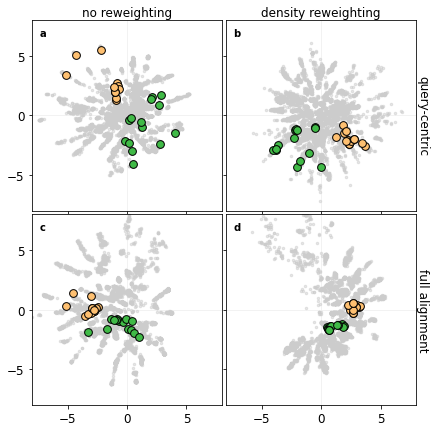

In [23]:
import matplotlib.pyplot as plt

titles = ["query-centric","full alignment","no reweighting","density reweighting"]

fig, ax = plt.subplots(2, len(models)//2, figsize=(len(models)*3/2,len(models)*3/2), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.02, hspace=0.02, left=0.06, right=0.95, bottom=0.06, top=0.95)

ax[0,1].yaxis.set_label_position('right')
ax[0,1].set_ylabel(titles[0], rotation=270, labelpad=13, fontsize=12)
ax[1,1].yaxis.set_label_position('right')
ax[1,1].set_ylabel(titles[1], rotation=270, labelpad=13, fontsize=12)
ax[0,0].xaxis.set_label_position('top')
ax[0,0].set_xlabel(titles[2], fontsize=12)
ax[0,1].xaxis.set_label_position('top')
ax[0,1].set_xlabel(titles[3], fontsize=12)

labels = ['a', 'b', 'c', 'd']

blue = np.array([.13, .35, .61])
green = np.array([.25, .73, .28])
yellow = np.array([254,192,113])/255.0
purple = [.42, .16, .42]

for k, model in enumerate(models):
    
    i = k//2
    j = k%2

    embedded = embeddings[k]
    a1_zs = zs[k]['A1']
    a2_zs = zs[k]['A2']
    
    ax[i,j].axvline(x=0, color='0.95', zorder=0, lw=1)
    ax[i,j].axhline(y=0, color='0.95', zorder=0, lw=1)
    ax[i,j].plot(embedded[:,0],
               embedded[:,1],
               '.', color='0.8', markersize=5, alpha=0.5, zorder=1)
    ax[i,j].scatter(a1_zs[:,0], a1_zs[:,1], color=green, s=60, zorder=2, edgecolors='black', alpha=1.0)
    ax[i,j].scatter(a2_zs[:,0], a2_zs[:,1], color=yellow, s=60, zorder=2, edgecolors='black', alpha=1.0)
    ax[i,j].set_xticks([])
    ax[i,j].set_yticks([])
    ax[i,j].set_xticks([-5, 0, 5])
    ax[i,j].set_yticks([-5, 0, 5])
    ax[i,j].set_xlim([-8,8])
    ax[i,j].set_ylim([-8,8])
    ax[i,j].set(aspect='equal')
    ax[i,j].tick_params(axis='both', which='major', labelsize=12)
    ax[i,j].text(0.04, 0.96, labels[k], transform=ax[i,j].transAxes, fontweight='bold', fontsize=10, verticalalignment='top')

plt.savefig('embeddings.svg')


[None]

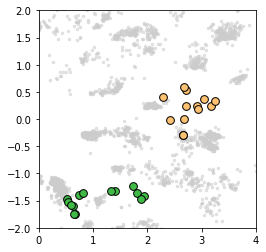

In [27]:
fig, ax = plt.subplots()
embedded = embeddings[-1]
a1_zs = zs[-1]['A1']
a2_zs = zs[-1]['A2']
ax.plot(embedded[:,0],
        embedded[:,1],
        '.', color='0.8', markersize=5, alpha=0.5, zorder=1)
ax.scatter(a1_zs[:,0], a1_zs[:,1], color=green, s=60, zorder=2, edgecolors='black', alpha=1.0)
ax.scatter(a2_zs[:,0], a2_zs[:,1], color=yellow, s=60, zorder=2, edgecolors='black', alpha=1.0)
    
ax.set_xlim([0,4])
ax.set_ylim([-2,2])
ax.set(aspect='equal')
    


# Calculating geodesic

In [8]:
# Continuing with last model
model = models[-1]

# Picking two points to interpolate between
p1 = zs[-1]['A1'][2]
p2 = zs[-1]['A2'][1]
print("Interpolating between {} and {}".format(p1, p2))

# Linear interpolant
t = np.linspace(0, 1, 100)[:,None]
linear = t*(p2-p1)[None,:]+p1

# Geodesic interpolant


Interpolating between [ 2.224162  -2.2215707] and [ 3.1500242 -1.4500315]


# Experiment 8 plot

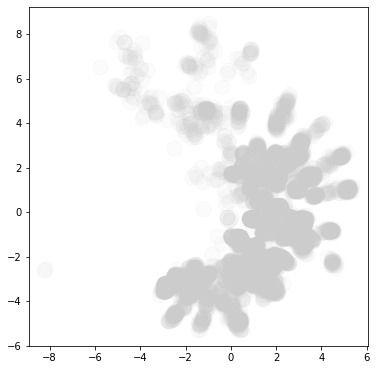

In [9]:
fig, ax = plt.subplots(figsize=(4.8,4.8))

plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.99)
plt.plot(embedded[:,0],
         embedded[:,1],
         '.', color='0.8', markersize=30, alpha=0.075, zorder=1)